In [14]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.transforms import functional as F


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
dataset = Cityscapes(
    root='../input/cityscape-semantic-dataset/data',
    split='train',
    mode='fine',
    target_type='semantic'
)

print("Done")

Done


In [16]:
#mask = transforms.PILToTensor()(mask).squeeze(0)  

#RUN ONLY ONCE 

## EDA- Check

In [17]:
dataset[0][0].size

(2048, 1024)

In [18]:
mask_np = np.array(mask)
np.unique(mask_np)

array([255])

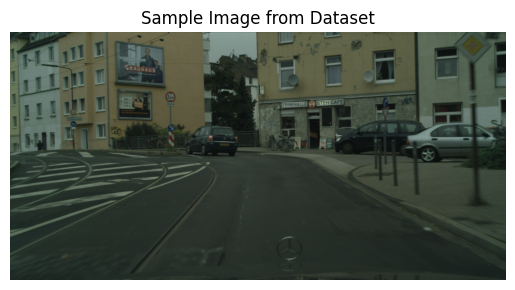

In [19]:
import matplotlib.pyplot as plt

img, _ = dataset[0]

plt.imshow(img)
plt.title("Sample Image from Dataset")
plt.axis("off")
plt.show()

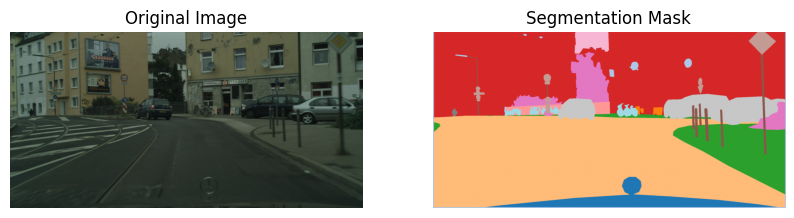

In [20]:
img, mask = dataset[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="tab20")
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()

### Create a wrapped dataset

In [21]:
class CityscapesTrainDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, img_transform, mask_transform):
        self.base = base_dataset
        self.img_tf = img_transform
        self.mask_tf = mask_transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]

        img = self.img_tf(img)

        mask = self.mask_tf(mask).squeeze(0)

        new_mask = torch.full_like(mask, 255)
        for old_id, new_id in CITYSCAPES_ID_MAP.items():
            new_mask[mask == old_id] = new_id

        return img, new_mask.long()

In [22]:
train_ds = CityscapesTrainDataset(
    dataset,
    img_transform,
    mask_transform
)

loader = DataLoader(
    train_ds,          
    batch_size=4,
    shuffle=True,
    num_workers=2
)


criterion = nn.CrossEntropyLoss(ignore_index=255)

print("Done")

Done


## Resizing

In [23]:
img_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),   
])


img, mask = dataset[0]

img_t = img_transform(img)
mask_t = mask_transform(mask)


print("Image min/max:", img_t.min().item(), img_t.max().item())


print("Mask unique values:", torch.unique(mask_t))

Image min/max: 0.03921568766236305 0.7607843279838562
Mask unique values: tensor([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26, 33],
       dtype=torch.uint8)


## Relabeling

In [24]:
CITYSCAPES_ID_MAP = {
     7: 0,   # road
     8: 1,   # sidewalk
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    17: 5,   # pole
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18   # bicycle
}

In [25]:
new_mask = torch.full_like(mask_t, 255)

for old_id, new_id in CITYSCAPES_ID_MAP.items():
    new_mask[mask == old_id] = new_id

mask = new_mask.long()

torch.unique(mask).tolist()

[255]

### Why Some Class IDs Are Missing (e.g., 3, 6, 9)

Cityscapes defines **19 possible classes** (0–18), but **each image only contains a subset of them**.

In this image:
- Classes `3`, `6`, `9`, etc. **do not appear**
- Therefore, they are **absent from `torch.unique(mask)`**

This is normal and expected.

**Important:**
- Missing class IDs ≠ missing from the dataset
- The model must still output **all 19 classes**
- Other images will contain the missing classes

**Conclusion:**  
The mask is correct; the missing numbers simply mean those objects are not present in this scene.

**Simple plot to check**

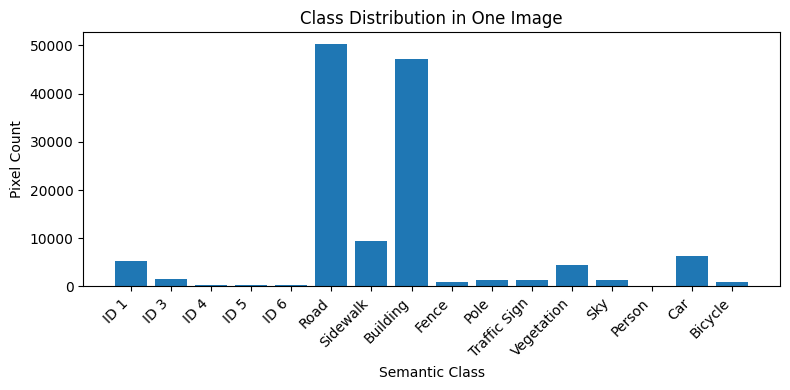

In [26]:
CLASS_NAMES = {
    7: "Road",
    8: "Sidewalk",
    11: "Building",
    12: "Wall",
    13: "Fence",
    17: "Pole",
    19: "Traffic Light",
    20: "Traffic Sign",
    21: "Vegetation",
    22: "Terrain",
    23: "Sky",
    24: "Person",
    25: "Rider",
    26: "Car",
    27: "Truck",
    28: "Bus",
    31: "Train",
    32: "Motorcycle",
    33: "Bicycle"
}


mask_np = np.array(mask_t)
values, counts = np.unique(mask_np, return_counts=True)

labels = [CLASS_NAMES.get(v, f"ID {v}") for v in values]

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xlabel("Semantic Class")
plt.ylabel("Pixel Count")
plt.title("Class Distribution in One Image")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Class IDs 1–6 correspond to non-semantic or void regions defined by the Cityscapes annotation protocol and are excluded from training and evaluation.**

## 1st Model: FCN-ResNet50.

In [27]:
from torchvision.models.segmentation import fcn_resnet50
from tqdm import tqdm
import torch

# Device FIRST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model_fcn = fcn_resnet50(num_classes=19)
model_fcn = model_fcn.to(device)

# Optimizer
optimizer = torch.optim.Adam(model_fcn.parameters(), lr=1e-4)

# Training loop
model_fcn.train()

num_epochs = 14

for epoch in range(num_epochs):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model_fcn(imgs)["out"]   # [B, C, H, W]
        loss = criterion(outputs, masks)   # masks: [B, H, W]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]


Epoch 1: Avg Loss = 0.3858


Epoch 2: Avg Loss = 0.2506


Epoch 3: Avg Loss = 0.2118


Epoch 4: Avg Loss = 0.1887


Epoch 5: Avg Loss = 0.1762


Epoch 6: Avg Loss = 0.1629


Epoch 7: Avg Loss = 0.1429


Epoch 8: Avg Loss = 0.1305


Epoch 9: Avg Loss = 0.1385


Epoch 10: Avg Loss = 0.1454


Epoch 11: Avg Loss = 0.1185


Epoch 12: Avg Loss = 0.1073


Epoch 13: Avg Loss = 0.1007


Epoch 14: Avg Loss = 0.0975


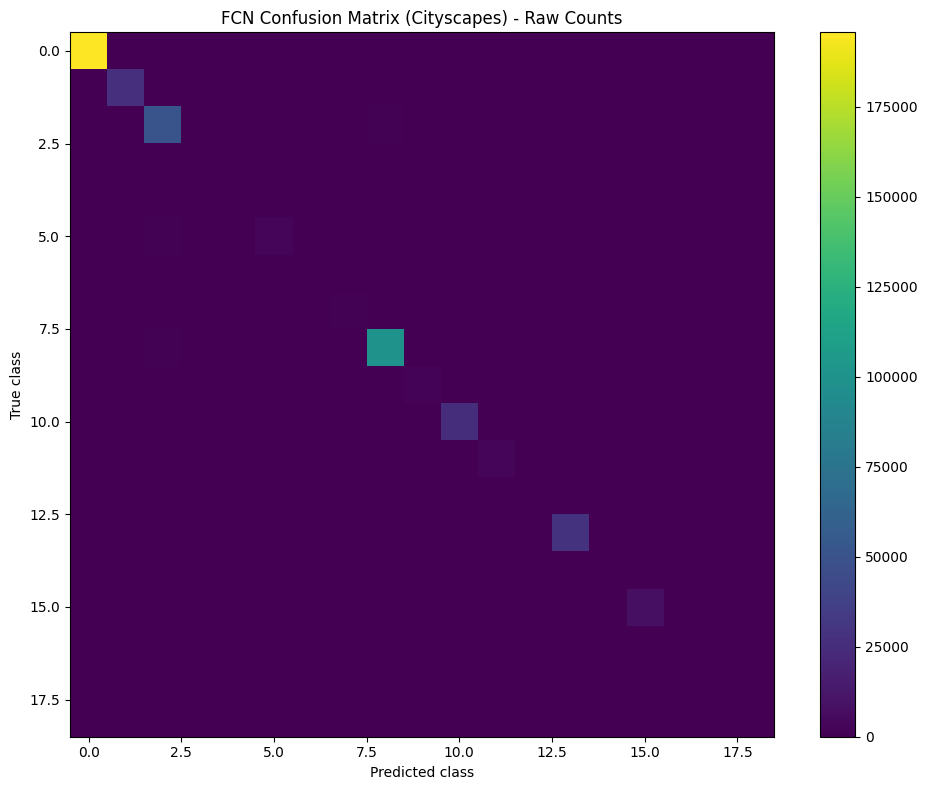

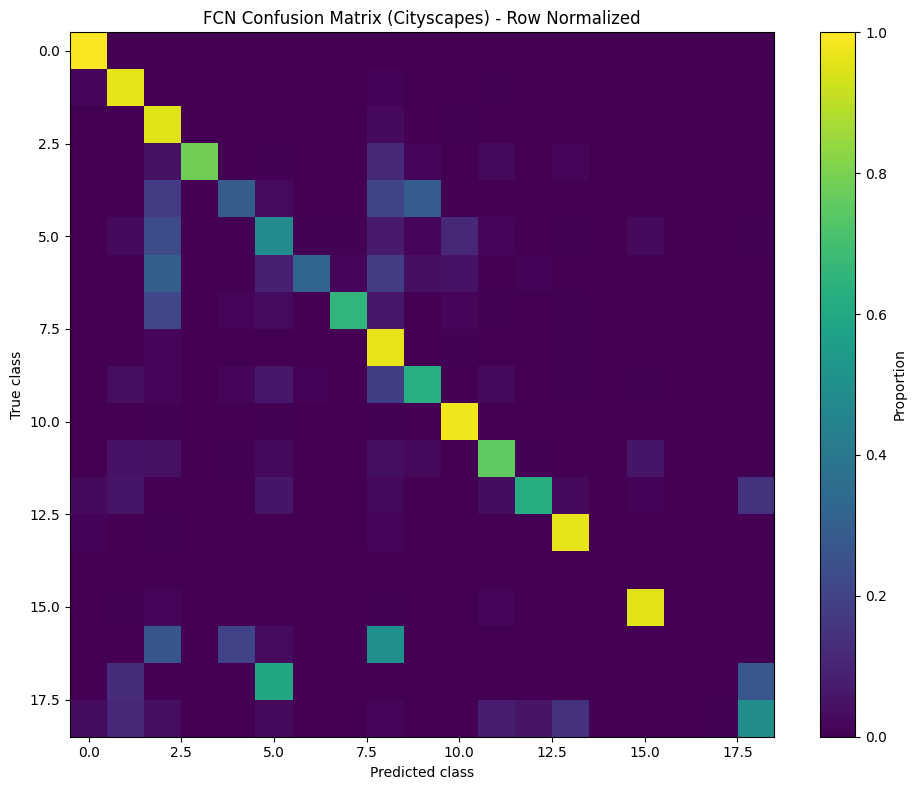

In [40]:
model_fcn.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model_fcn(imgs)["out"]
    preds = torch.argmax(outputs, dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid]
masks = masks[valid]

preds = preds.cpu()
masks = masks.cpu()

# Number of classes (Cityscapes)
num_classes = 19

# Create confusion matrix
cm_fcn = torch.zeros(num_classes, num_classes, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm_fcn[t, p] += 1

# -------- RAW CONFUSION MATRIX --------
plt.figure(figsize=(10, 8))
plt.imshow(cm_fcn, interpolation="nearest")
plt.colorbar()
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("FCN Confusion Matrix (Cityscapes) - Raw Counts")
plt.tight_layout()
plt.show()

# -------- NORMALIZED CONFUSION MATRIX --------
cm_fcn_float = cm_fcn.float()
cm_fcn_norm = cm_fcn_float / (cm_fcn_float.sum(dim=1, keepdim=True) + 1e-8)

plt.figure(figsize=(10, 8))
plt.imshow(cm_fcn_norm, interpolation="nearest", vmin=0.0, vmax=1.0)
plt.colorbar(label="Proportion")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("FCN Confusion Matrix (Cityscapes) - Row Normalized")
plt.tight_layout()
plt.show()


### Raw Confusion Matrix (Pixel Counts)

The raw confusion matrix **shows how many pixels** were predicted as each class compared to their true class.

***Rows represent the true class of a pixel***.

***Columns represent the class predicted by the model***.

Each cell shows the **number of pixels** that fall into that true–predicted class pair.

The bright diagonal line means that many pixels were **classified correctly**.
Large values off the diagonal mean the model is confusing one class with another.

Because some classes (like road or building) appear much more often than others, their pixel counts are very large. This makes the raw matrix hard to interpret visually, especially for rare classes such as poles, traffic lights, or riders.

This matrix is mainly useful to confirm that the confusion matrix is computed correctly.

### Normalized Confusion Matrix (Proportions)

The normalized confusion matrix shows the **same information**, but in a clearer way.

Each row is scaled so that the values add up to 1.

Each cell **shows the percentage of pixels of a true class** that were predicted as each class.

This makes the matrix easier to read because **all classes are treated equally**, even if some appear less often in the dataset.

#### Bright values on the diagonal mean the model is good at recognizing that class.

#### Bright values off the diagonal show which classes are commonly confused.

This matrix helps understand how the model behaves for each class, rather than being dominated by large pixel counts.

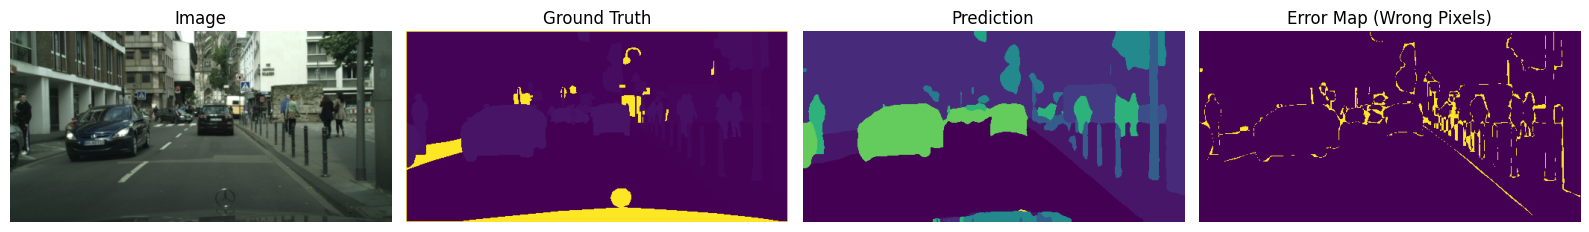

In [44]:
# ---------- Visualizing predictions and errors ----------

model_fcn.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model_fcn(imgs)["out"]
    preds = outputs.argmax(dim=1)

# Take first image in batch
img = imgs[0].cpu().permute(1, 2, 0)
gt  = masks[0].cpu()
pr  = preds[0].cpu()

valid = gt != 255
error = (pr != gt) & valid

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(gt)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pr)
plt.title("Prediction")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(error)
plt.title("Error Map (Wrong Pixels)")
plt.axis("off")

plt.tight_layout()
plt.show()


### Model Architecture Summary

The model summary provides a structured overview of the neural network used in this project.

It shows each major layer in the network and how data flows through the model from input to output. For every layer, the summary lists the output shape and the number of learnable parameters. This helps verify that the network is built correctly and that the input and output dimensions match the semantic segmentation task.

Because the model is fully convolutional, it preserves spatial information throughout the network. The final output has the same height and width as the input image, allowing the model to assign a class label to every pixel.

This summary is useful for understanding the overall structure of the network without visual clutter, and it confirms that the model architecture is suitable for pixel-level prediction.

### 2nd Model: DeepLabV3-ResNet50

In [41]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(num_classes=19)

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

for epoch in range(14):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")

Epoch 1: Avg Loss = 0.2665


Epoch 2: Avg Loss = 0.2249


Epoch 3: Avg Loss = 0.1961


Epoch 4: Avg Loss = 0.1803


Epoch 5: Avg Loss = 0.1685


Epoch 6: Avg Loss = 0.1593


Epoch 7: Avg Loss = 0.1429


Epoch 8: Avg Loss = 0.1415


Epoch 9: Avg Loss = 0.1279


Epoch 10:   5%|▍         | 34/744 [00:26<09:10,  1.29it/s, loss=0.0997]

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50

# Define device ONCE, as a torch.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Recreate + move model (guarantees weights are on GPU if available)
model = deeplabv3_resnet50(num_classes=19).to(device)
model.eval()

# Sanity check: confirm model really moved
print("Model params device:", next(model.parameters()).device)


In [ ]:
model.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(imgs)["out"]
    preds = outputs.argmax(dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid].cpu()
masks = masks[valid].cpu()

cm_dl = torch.zeros(19, 19, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm_dl[t, p] += 1

plt.figure(figsize=(10, 8))
plt.imshow(cm_dl, interpolation="nearest")
plt.colorbar()
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("DeepLabV3 Confusion Matrix (Cityscapes)")
plt.tight_layout()
plt.show()


### Comparissons

In [ ]:
import matplotlib.pyplot as plt

imgs_vis, masks_vis = next(iter(loader))

imgs_vis = imgs_vis.to(device)
masks_vis = masks_vis.to(device)

model.eval()
model_fcn.eval()

with torch.no_grad():
    pred_dl = torch.argmax(model(imgs_vis)["out"], dim=1)
    pred_fcn = torch.argmax(model_fcn(imgs_vis)["out"], dim=1)

i = 0

img = imgs_vis[i].cpu().permute(1, 2, 0)   
dl  = pred_dl[i].cpu()                    
fcn = pred_fcn[i].cpu()                   


plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(dl, cmap="tab20")
plt.title("DeepLabV3 Prediction")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(fcn, cmap="tab20")
plt.title("FCN Prediction")
plt.axis("off")

plt.show()

In [ ]:
import matplotlib.pyplot as plt

imgs_vis, masks_vis = next(iter(loader))

imgs_vis = imgs_vis.to(device)
masks_vis = masks_vis.to(device)

model.eval()
model_fcn.eval()

with torch.no_grad():
    pred_dl = torch.argmax(model(imgs_vis)["out"], dim=1)
    pred_fcn = torch.argmax(model_fcn(imgs_vis)["out"], dim=1)

i = 0

img = imgs_vis[i].cpu().permute(1, 2, 0)   
dl  = pred_dl[i].cpu()                    
fcn = pred_fcn[i].cpu()                   

CITYSCAPES_CLASS_NAMES = {
    0: "Road",
    1: "Sidewalk",
    2: "Building",
    3: "Wall",
    4: "Fence",
    5: "Pole",
    6: "Traffic Light",
    7: "Traffic Sign",
    8: "Vegetation",
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Truck",
    14: "Car",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}



cmap = plt.get_cmap("tab20")

legend_patches = [
    mpatches.Patch(color=cmap(i), label=CITYSCAPES_CLASS_NAMES[i])
    for i in range(len(CITYSCAPES_CLASS_NAMES))
]


plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(dl, cmap="tab20")
plt.title("DeepLabV3 Prediction")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(fcn, cmap="tab20")
plt.title("FCN Prediction")
plt.axis("off")

plt.legend(
    handles=legend_patches,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)

plt.show()

In [ ]:
def mean_iou(cm):
    intersection = cm.diag()
    union = cm.sum(1) + cm.sum(0) - cm.diag()
    iou = intersection / union.clamp(min=1)
    return iou.mean().item(), iou

miou_dl, iou_dl = mean_iou(cm_dl)
miou_fcn, iou_fcn = mean_iou(cm_fcn)

print("DeepLab mIoU:", round(miou_dl, 4))
print("FCN mIoU:", round(miou_fcn, 4))

In [ ]:
!apt-get -y install graphviz
!pip -q install torchview graphviz

from torchview import draw_graph

model_fcn.eval()

graph = draw_graph(
    model_fcn,
    input_size=(1, 3, 256, 512),
    expand_nested=True,
    graph_name="FCN_ResNet50",
    save_graph=True,
    filename="fcn_resnet50_graph",
    directory="."
)

graph.visual_graph
